In [108]:
import os
from pathlib import Path
PARENT_PATH = Path(os.getcwd()).parent.absolute()
import pandas as pd

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections


import nltk
from nltk.corpus import stopwords
import re
#import networkx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [109]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)

In [110]:
# load data
xls = pd.ExcelFile(os.path.join(data.data_path, "Regulatory Requirements.xlsx"))
df = pd.read_excel(xls,'Requirements List')

In [111]:
# data shape
print("Shape of df is: ", df.shape)
print(sum(df['Standard mapping?'].isna())/df.shape[0]*100, "percent of data doesn't get mapped to a lable.")
print(df.value_counts('Mapped to a standard?'))

Shape of df is:  (10232, 13)
61.82564503518374 percent of data doesn't get mapped to a lable.
Mapped to a standard?
No mapping              6326
Mapped to a standard    3906
dtype: int64


In [112]:
# data preprocess
df1 = df[df['Mapped to a standard?'] != 'No mapping']
df1.reset_index(drop=True, inplace=True)
df1['Standard mapping?'].replace('\n',',', regex=True,inplace = True)
df1['Standard mapping?'] = df1['Standard mapping?'].str.replace(r'^[\s,]+|[\s,]+$|(\s)*(,)[\s,]*', r'\2\1', regex=True)
df1['Standard mapping?'] = df1['Standard mapping?'].str.split(',')

In [113]:
n = df1.shape[0]
for i in range(n):
    for j in range(len(df1['Standard mapping?'][i])):
        if df1['Standard mapping?'][i][j].lower() == 'vmp':
            df1['Standard mapping?'][i][j] = 'VMP'

# number of samples by category

In [114]:
df2 = df1.copy()

In [115]:
labels_dict = {}
for i in range(df2.shape[0]):
    for j in range(len(df2['Standard mapping?'][i])):
        label = df2['Standard mapping?'][i][j].strip()
        if label == '':
            continue
        if label not in list(labels_dict.keys()):
            labels_dict[label] = 1
        else:
            labels_dict[label] += 1

In [116]:
sorted_dict = dict(sorted(labels_dict.items(), key=lambda item: item[1]))

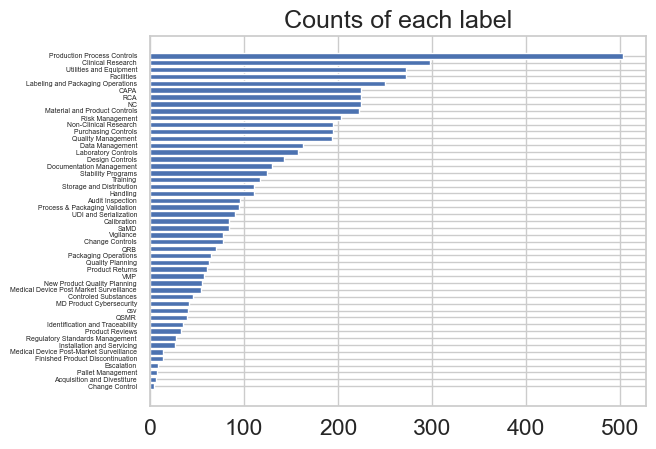

In [117]:
import matplotlib.pyplot as plt

names = list(sorted_dict.keys())
values = list(sorted_dict.values())

plt.barh(range(len(labels_dict)), values, tick_label=names)
plt.yticks(fontsize=5)
plt.title('Counts of each label')
plt.show()

### number of samples by category for each Regulatory Requirement Type

In [118]:
df.value_counts('Regulatory Requirement Type')

Regulatory Requirement Type
Core        6316
Non-Core    2855
Obsolete     849
Non-core     168
non-core      44
dtype: int64

In [119]:
# group Regulatory Requirement Type
map_type = {'Non-core':'Non-Core', 'non-core':'Non-Core'}
df = df.replace({'Regulatory Requirement Type':map_type})
df.value_counts('Regulatory Requirement Type')

Regulatory Requirement Type
Core        6316
Non-Core    3067
Obsolete     849
dtype: int64

In [120]:
count_label_core = count_label(df_map[df_map['Regulatory Requirement Type']=='Core'])
count_label_noncore = count_label(df_map[df_map['Regulatory Requirement Type']=='Non-Core'])
count_label_obs = count_label(df_map[df_map['Regulatory Requirement Type']=='Obsolete'])

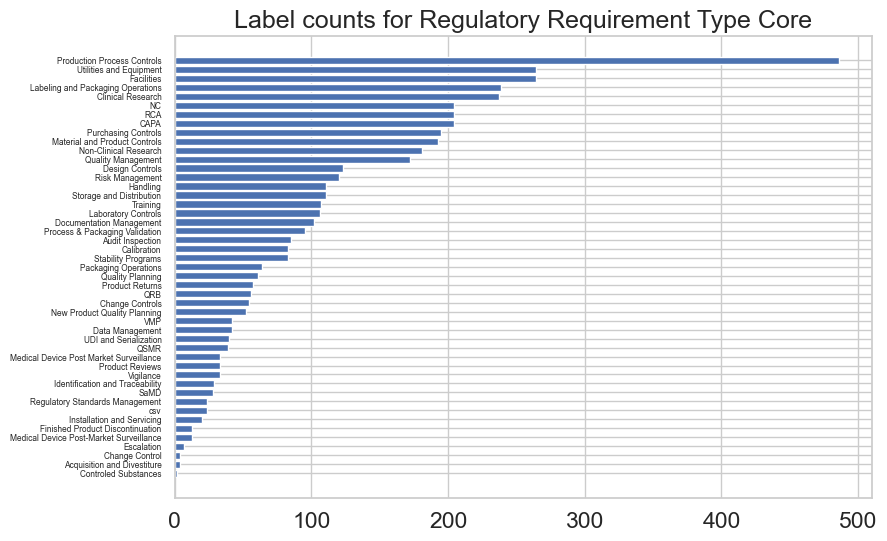

In [121]:
fig,ax = plt.subplots(figsize=(9,6))
plt.barh(y=count_label_core['label'],width=count_label_core['count'])
plt.yticks(fontsize=6)
plt.title('Label counts for Regulatory Requirement Type Core')
plt.show()

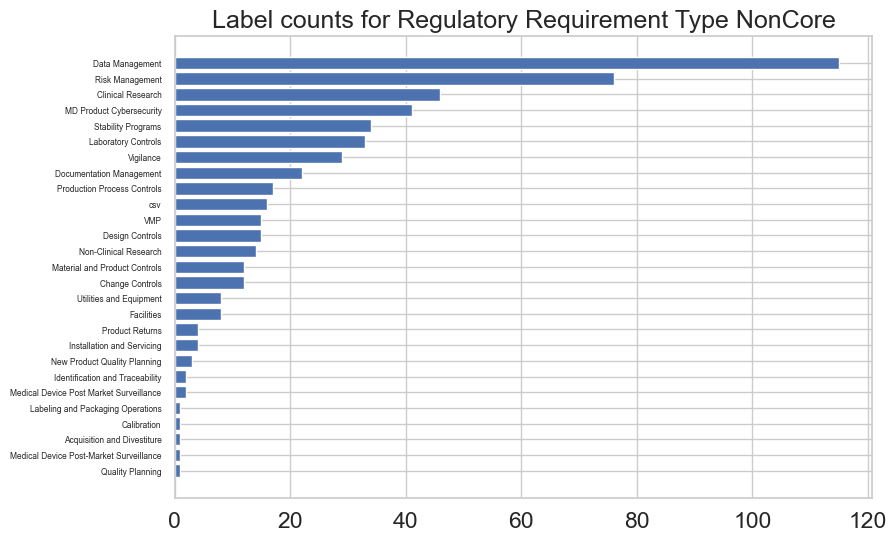

In [122]:
fig,ax = plt.subplots(figsize=(9,6))
plt.barh(y=count_label_noncore['label'],width=count_label_noncore['count'])
plt.yticks(fontsize=6)
plt.title('Label counts for Regulatory Requirement Type NonCore')
plt.show()

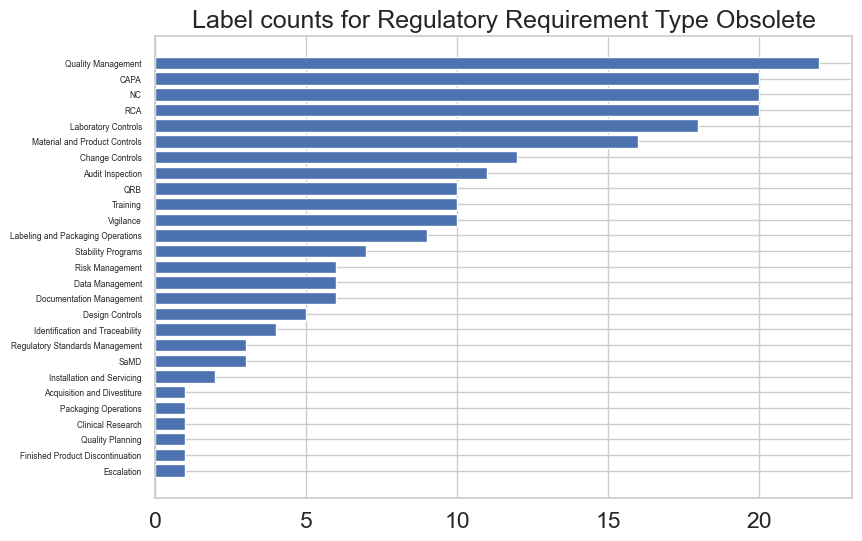

In [123]:
fig,ax = plt.subplots(figsize=(9,6))
plt.barh(y=count_label_obs['label'],width=count_label_obs['count'])
plt.yticks(fontsize=6)
plt.title('Label counts for Regulatory Requirement Type Obsolete')
plt.show()

# word frequency analysis

In [124]:
# extract all the words from text, not including numbers
df3 = df2.copy()
for i in range(df3.shape[0]):
    df3['Text'][i] = " ".join(re.sub("([^A-Za-z \t])|(\w+:\/\/\S+)", "", df3['Text'][i]).split())
    #df3['Text'][i] = " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", df3['Text'][i]).split())
    df3['Text'][i] = df3['Text'][i].lower().split()
    words = df3['Text'][i]   

In [125]:
# exclude all the stop_words including 'shall'
stop_words = set(stopwords.words('english'))
df3['Text'] = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in df3['Text']]
df3['Text'] = [[word for word in tweet_words if word != 'shall']
              for tweet_words in df3['Text']]

In [126]:
texts = df3['Text']
all_words = list(itertools.chain(*texts))
counts_words = collections.Counter(all_words)
counts_words.most_common(15)

[('quality', 2243),
 ('product', 1661),
 ('control', 1308),
 ('device', 1248),
 ('data', 1127),
 ('products', 1110),
 ('materials', 991),
 ('management', 983),
 ('system', 968),
 ('procedures', 866),
 ('appropriate', 865),
 ('requirements', 864),
 ('production', 863),
 ('manufacturer', 859),
 ('process', 856)]

Text(0.5, 1.0, 'Common Words Found in Texts (Without Stop Words)')

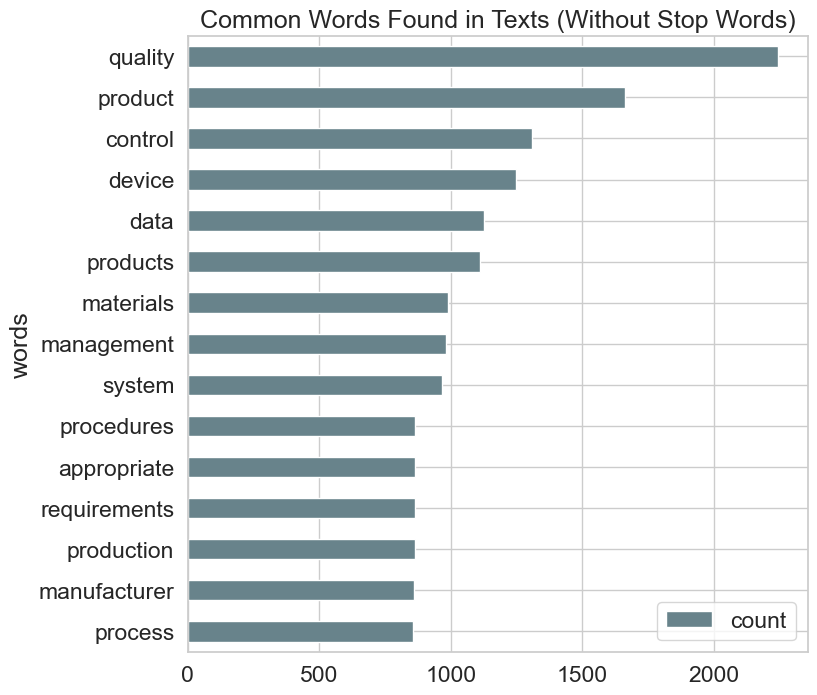

In [127]:
clean_texts = pd.DataFrame(counts_words.most_common(15),
                             columns=['words', 'count'])
fig, ax = plt.subplots(figsize=(8, 8))
# Plot horizontal bar graph
clean_texts.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="#68838B")
ax.set_title("Common Words Found in Texts (Without Stop Words)")


# sentence length analysis

In [128]:
names = list(sorted_dict.keys())
values = list(sorted_dict.values())

In [129]:
lengths = []
counts = []
for name in names:
    count = 0
    length = 0
    for i in range(len(df2['Text'])):
        if name in df2['Standard mapping?'][i]:
            count += 1
            length += len(df2['Text'][i])
    counts.append(count)
    lengths.append(length)          

In [130]:
avg_len = []
for i in range(len(names)):
    if counts[i] == 0:
        print(counts[i])
        avg_len.append(0)
    else:
        avg_len.append(round(lengths[i]/counts[i],2))

In [131]:
data_tuples = list(zip(names,avg_len))
df_len = pd.DataFrame(data_tuples, columns=['labels','avg_len'])

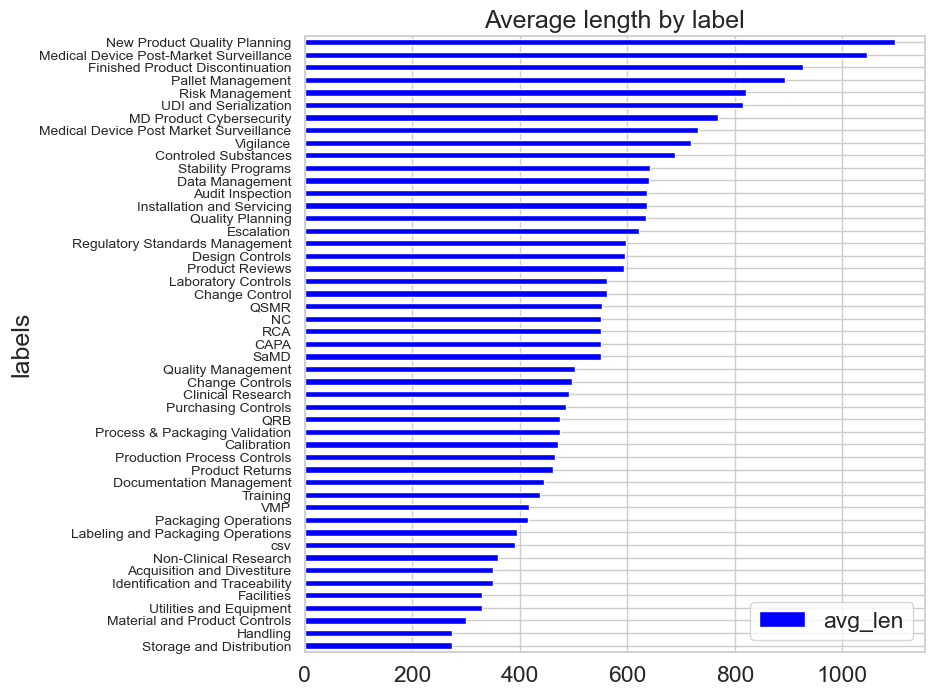

In [132]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot horizontal bar graph
df_len.sort_values(by='avg_len').plot.barh(x='labels',y='avg_len',ax=ax,
                                         color="blue")
ax.set_title("Average length by label")
ax.yaxis.set_tick_params(labelsize=10)

# distribution of length

In [133]:
df4 = df3.copy()
text_length = []
for i in range(len(df4['Text'])):
    text_length.append(len(df4['Text'][i]))
df4['Text_length'] = text_length

Text(0, 0.5, 'Counts')

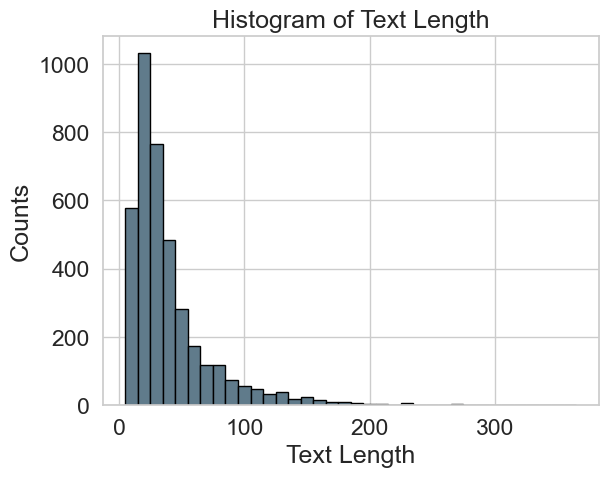

In [134]:
# matplotlib histogram
plt.hist(df4['Text_length'], color = '#607B8B', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Counts')


In [135]:
print("test")

test


# N-gram

In [136]:
import re
import nltk
from nltk.corpus import stopwords
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
df = df[df['Text'].isna()==False]
def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

df['Text_clean'] = df.Text.apply(clean_text)

In [137]:
statement = df['Text_clean'].str.split()
statement=statement.values.tolist()
corpus=[word for i in statement for word in i]
counter=Counter(corpus)
word_freq=counter.most_common()

words, counts = [], []
for word,count in word_freq[:20]:
    words.append(word)
    counts.append(count)

In [138]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vectorizer = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq
top_n_bigrams4 = get_top_ngram(df['Text_clean'],4)[:20] 
ngram_4, count_4 = map(list,zip(*top_n_bigrams4)) 
top_n_bigrams3=get_top_ngram(df['Text_clean'],3)[:20] 
ngram_3, count_3 = map(list,zip(*top_n_bigrams3)) 
top_n_bigrams2 = get_top_ngram(df['Text_clean'],2)[:20] 
ngram_2, count_2 = map(list,zip(*top_n_bigrams2)) 

<Figure size 2000x2500 with 0 Axes>

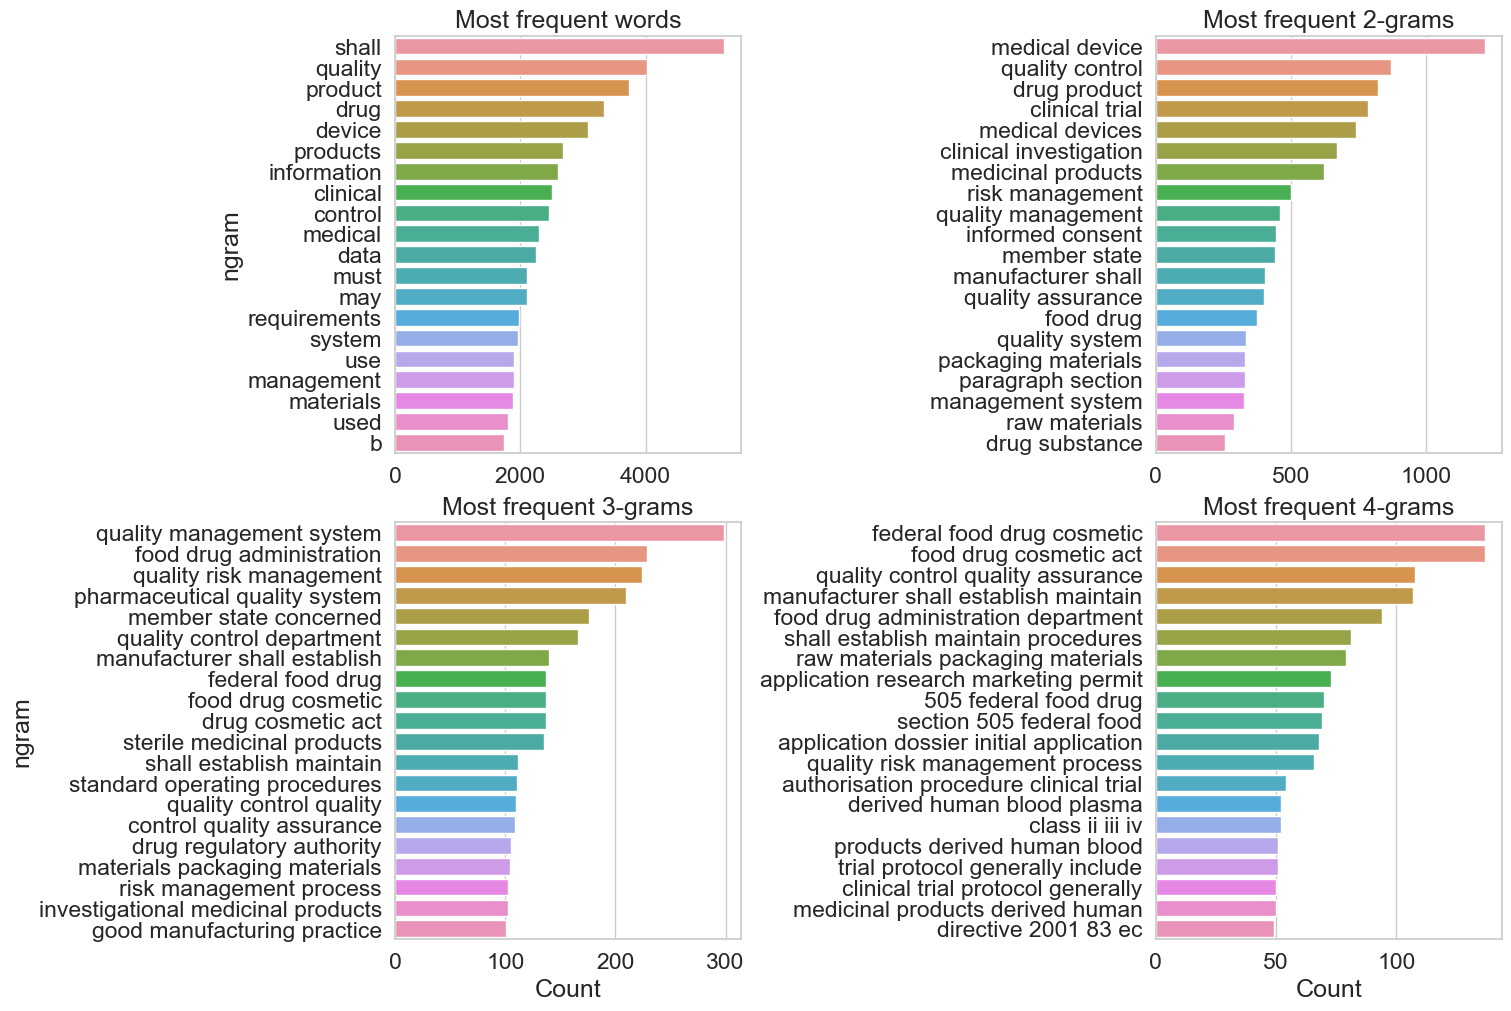

In [139]:
fig = plt.figure()
fig.set_figheight(25) 
fig.set_figwidth(20)
fig,ax = plt.subplots(2, 2, figsize = (15,10), constrained_layout=True)

sns.barplot(x=counts[:20],y=words[:20],ax=ax[0,0])
ax[0,0].set_ylabel('ngram')
ax[0,0].set_title('Most frequent words')

sns.barplot(x=count_2,y=ngram_2, ax=ax[0,1])
ax[0,1].set_title('Most frequent 2-grams')

sns.barplot(x=count_3,y=ngram_3, ax=ax[1,0])
ax[1,0].set_xlabel('Count')
ax[1,0].set_ylabel('ngram')
ax[1,0].set_title('Most frequent 3-grams')

sns.barplot(x=count_4,y=ngram_4, ax=ax[1,1])
ax[1,1].set_xlabel('Count')
ax[1,1].set_title('Most frequent 4-grams')

plt.show()